In [5]:
!pip install plotly

In [6]:
# Initial imports
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly
from sklearn.cluster import KMeans, k_means
from pathlib import Path
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# SQL Alchemy
from sqlalchemy import create_engine

In [7]:
#Loading Data from SQL database
protocol = 'postgresql'
username = 'postgres'
password = 'password'
host = 'localhost'
port = 5432
database_name = 'ecom'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)

In [41]:
#Examine table data and save into a dataframe
customers = pd.read_sql_query('select * from customer_summaries', con=engine)
customers.head()

,user_id,order_count,avg_hour,avg_prior,resum,strpro,proco,ordersize
0,7,24,18.0,30.0,20.0,"21,59,38,108,24,31,120,26,96,96,96,112,31,31,3...",24.0,24.0
1,11,11,11.0,30.0,3.0,"17,19,36,17,123,88,115,32,53,77,115",11.0,11.0
2,13,10,8.0,7.0,6.0,"59,112,128,84,53,83,117,91,83,83",10.0,10.0
3,24,4,14.0,24.0,4.0,"78,106,98,23",4.0,2.0
4,31,5,17.0,0.0,1.0,"84,105,112,37,37",5.0,5.0


In [42]:
# drop nulls
customers = customers.dropna()

In [43]:
# Find null values
for column in customers.columns:
    print(f"Column {column} has {customers[column].isnull().sum()} null values")

Column user_id has 0 null values
Column order_count has 0 null values
Column avg_hour has 0 null values
Column avg_prior has 0 null values
Column resum has 0 null values
Column strpro has 0 null values
Column proco has 0 null values
Column ordersize has 0 null values


In [44]:
# drop unnecessary columns
customers = customers.drop(columns = ['strpro','user_id', 'proco'])
customers.head()

,order_count,avg_hour,avg_prior,resum,ordersize
0,24,18.0,30.0,20.0,24.0
1,11,11.0,30.0,3.0,11.0
2,10,8.0,7.0,6.0,10.0
3,4,14.0,24.0,4.0,2.0
4,5,17.0,0.0,1.0,5.0


In [45]:
# scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customers)

In [46]:
# create new dataframe from the scaled data
scaled_customers = pd.DataFrame(scaled_data, columns = customers.columns)
scaled_customers.head()

,order_count,avg_hour,avg_prior,resum,ordersize
0,0.241021,1.200868,1.930786,0.559702,1.976872
1,-0.409503,-0.675999,1.930786,-0.535644,0.130086
2,-0.459544,-1.480370,-0.542336,-0.342348,-0.011974
3,-0.759786,0.128372,1.285624,-0.471212,-1.148458
4,-0.709745,0.932744,-1.295025,-0.664508,-0.722276


In [47]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(scaled_customers)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.head()

,k,inertia
0,1,526365.000000
1,2,376562.229193
2,3,302357.497494
3,4,255275.596516
4,5,215769.186956


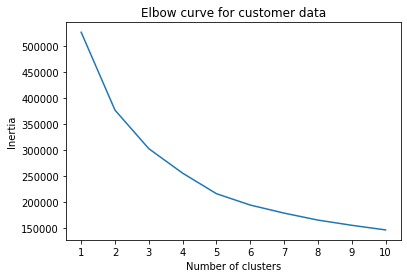

In [48]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for customer data')
plt.show()

Based on the above elbow curve, we will use 5 clusters for our clustering appraoch

In [49]:
# create cluster function
def get_clusters(k, data):
    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Train the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

In [56]:
# create clusters using the cluster count determined from the elbow curve using the scaled data
clusters = get_clusters(5, scaled_customers)
clusters

,order_count,avg_hour,avg_prior,resum,ordersize,class
0,0.241021,1.200868,1.930786,0.559702,1.976872,4
1,-0.409503,-0.675999,1.930786,-0.535644,0.130086,2
2,-0.459544,-1.480370,-0.542336,-0.342348,-0.011974,0
3,-0.759786,0.128372,1.285624,-0.471212,-1.148458,2
4,-0.709745,0.932744,-1.295025,-0.664508,-0.722276,1
...,...,...,...,...,...,...
105268,0.291061,0.364321,0.077020,0.173109,0.343177,4
105269,-0.759786,0.664620,-0.757390,-0.600076,-0.864337,1
105270,0.140940,0.201490,1.070570,-0.471212,0.130086,2
105271,-0.609665,-0.407875,1.930786,-0.406780,-0.438156,2


In [59]:
# create function to plot the clusters, in this case by average hour and avergae order size
def show_clusters(df):
    plt.scatter(df['avg_hour'], df['ordersize'], c=df['class'])
    plt.xlabel('avg_hour')
    plt.ylabel('average order size')
    plt.show()

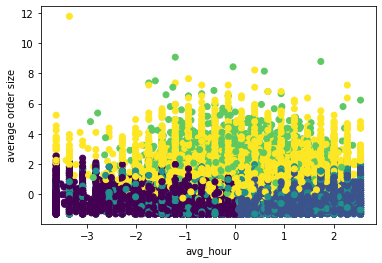

In [60]:
show_clusters(clusters)